In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [23]:
# ### Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import xgboost as xgb

In [5]:
# ## Load the Data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
train_df.sample(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
669,670,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
583,584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C
325,326,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C


In [6]:
train_df.describe()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Frequency counts for categorical columns
print(train_df['Pclass'].value_counts())
print(train_df['Sex'].value_counts())
print(train_df['Embarked'].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


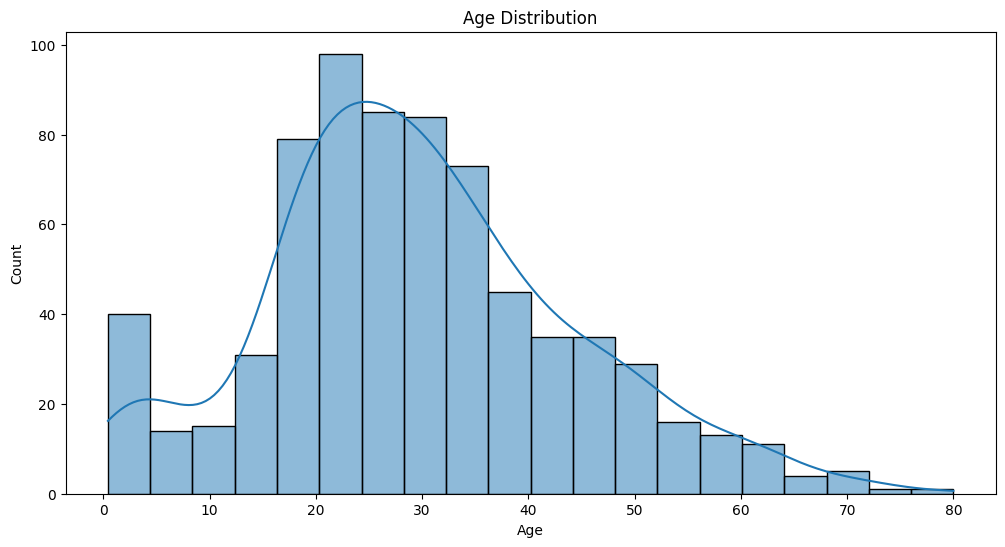

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


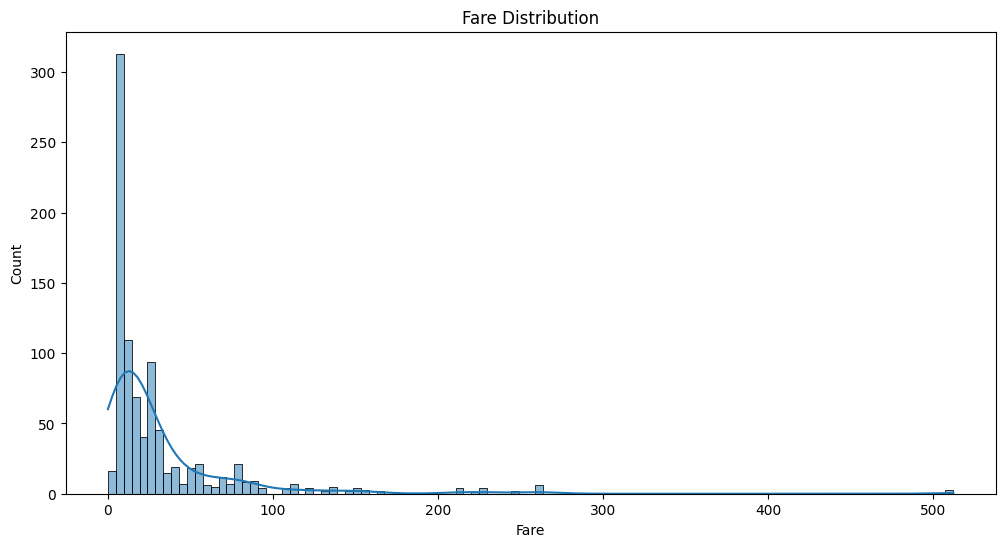

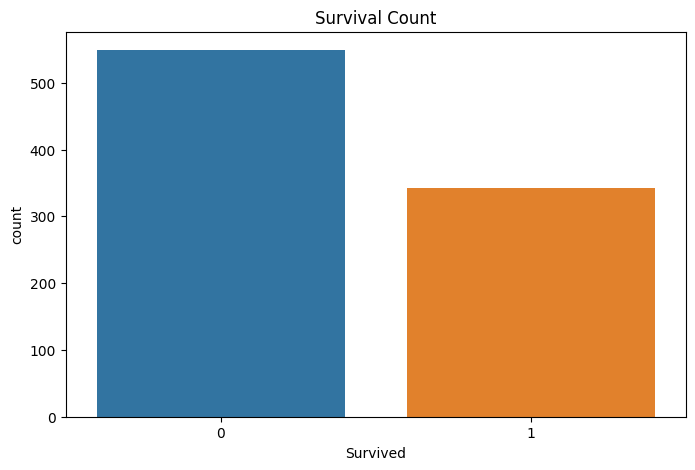

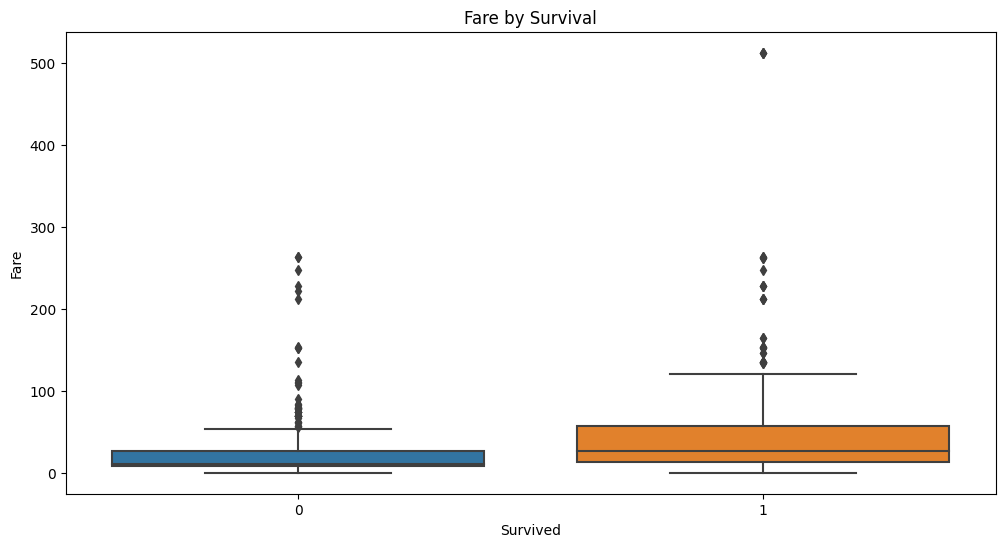

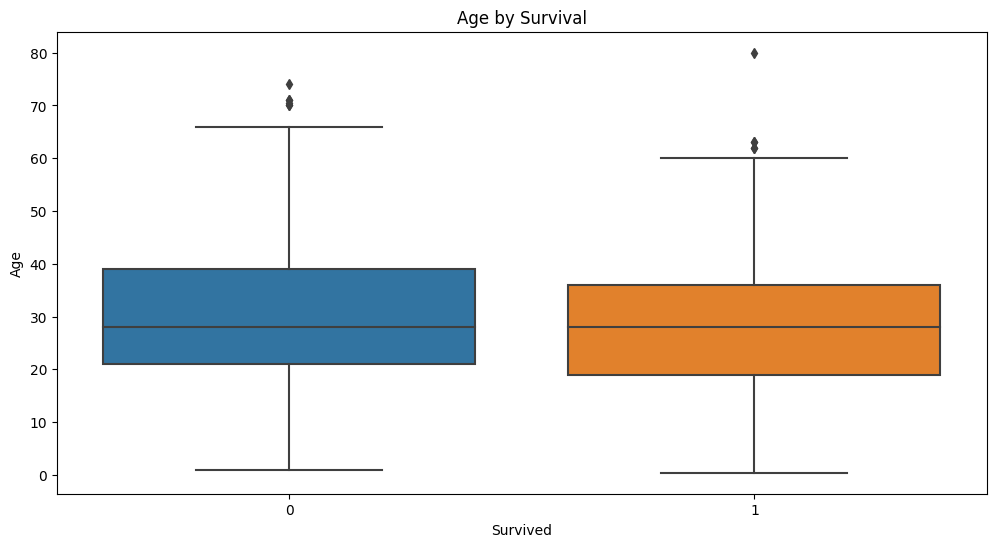

In [9]:
#Visualize distributions and relationships.
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of numerical features
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_df['Fare'], kde=True)
plt.title('Fare Distribution')
plt.show()

# Count plot for 'Survived'
plt.figure(figsize=(8, 5))
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Count')
plt.show()

# Box plot for Fare by Survival
plt.figure(figsize=(12, 6))
sns.boxplot(x='Survived', y='Fare', data=train_df)
plt.title('Fare by Survival')
plt.show()

# Age by Survival
plt.figure(figsize=(12, 6))
sns.boxplot(x='Survived', y='Age', data=train_df)
plt.title('Age by Survival')
plt.show()

In [10]:
#Handling Missing Values
# Handling missing values in 'Age'
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# Handling missing values in 'Embarked'
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Handling missing values in 'Cabin'
train_df['Cabin'] = train_df['Cabin'].fillna('U')  # Fill with 'U' for unknown

# Verify missing values
print(train_df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


/tmp/ipykernel_33/2924618000.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
/tmp/ipykernel_33/2924618000.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [11]:
train_df.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,U,S
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,U,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [12]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [13]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [14]:
# Label encode 'Sex'
label_encoder = LabelEncoder()
train_df['Sex'] = label_encoder.fit_transform(train_df['Sex'])

In [15]:
# One-hot encode 'Embarked'
train_df = pd.get_dummies(train_df, columns=['Embarked'], drop_first=True)

In [16]:
# Convert boolean to integer
train_df = train_df.astype(float)

In [17]:
train_df.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
104,0.0,3.0,1.0,37.0,2.0,0.0,7.9250,0.0,1.0
817,0.0,2.0,1.0,31.0,1.0,1.0,37.0042,0.0,0.0
424,0.0,3.0,1.0,18.0,1.0,1.0,20.2125,0.0,1.0
212,0.0,3.0,1.0,22.0,0.0,0.0,7.2500,0.0,1.0
20,0.0,2.0,1.0,35.0,0.0,0.0,26.0000,0.0,1.0
279,1.0,3.0,0.0,35.0,1.0,1.0,20.2500,0.0,1.0
754,1.0,2.0,0.0,48.0,1.0,2.0,65.0000,0.0,1.0
38,0.0,3.0,0.0,18.0,2.0,0.0,18.0000,0.0,1.0
866,1.0,2.0,0.0,27.0,1.0,0.0,13.8583,0.0,0.0
299,1.0,1.0,0.0,50.0,0.0,1.0,247.5208,0.0,0.0


In [19]:
# Define features (X) and target (y)
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       105
         1.0       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [25]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_:.2f}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Score: 0.83
